# Recommender-System-Evaluation-using-Embeddings

In [ ]:
import json
import time
import pandas as pd
import numpy as np
import scipy.sparse as sps

## We will use the [yelp-dataset](https://www.yelp.com/dataset/documentation/main)
We will get exactly the same set of data as before with the only difference being the retention of the information about when (date) each review was created such that we can order the reviews by date.

In [ ]:
business_data = '../dataset/yelp_academic_dataset_business.json'

toronto_business_ids = set()
start = time.process_time()
for line in open(business_data, 'r', encoding='utf8', errors='ignore'):
    data = json.loads(line)
    if data['city'] == 'Toronto' and data['review_count'] >= 15:
        toronto_business_ids.add(data['business_id'])

review_data_path = '../dataset/yelp_academic_dataset_review.json'
reviews = []
for line in open(review_data_path, 'r', encoding='utf8', errors='ignore'):
    data = json.loads(line)
    business_id = data['business_id']

    if business_id in toronto_business_ids:
        user_id = data['user_id']
        business_id = data['business_id']
        stars = int(data['stars'])
        date = data['date']
        review = [user_id, business_id, stars, date]
        reviews.append(review)

df = pd.DataFrame(reviews)
df.columns = ['user_id', 'business_id', 'stars', 'date']

df = df.drop_duplicates(subset=['user_id', 'business_id'], keep='last')

while True:
    old_lines = len(df)
    df = df.groupby('business_id').filter(lambda x: len(x) >= 15)
    df = df.groupby('user_id').filter(lambda x: len(x) >= 15)
    new_lines = len(df)
    if old_lines == new_lines:
        break

# write the dataframe on disk
csv_name = "../dataset/yelp_user_business.csv"
df.to_csv(csv_name, index=False, header=False)
print(f"Execution time = {time.process_time() - start}")

## Extracting the relevant information from the data

In [5]:
input_file = '../dataset/yelp_user_business.csv'
names = ['user_id', 'business_id', 'rating', 'date']

df = pd.read_csv(input_file, names=names, encoding='utf8', header=None)
df

,user_id,business_id,rating,date
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4,2017-06-06 19:04:10
1,AdMCAKmNDIaubYPxnjTq1g,nIIuxIn5RU0j-XkDWh3hlA,1,2018-10-04 14:12:57
2,1kNsEAhGU8d8xugMuXJGFA,cDoo0Pf1d_P79Rq3ZNk-Mw,3,2013-07-13 00:57:45
3,Kl6jNDAE7PG_VVQafIptxQ,IfUkm42SB9D0m_ZbkQ711A,4,2013-04-10 17:43:11
4,JnPIjvC0cmooNDfsa9BmXg,nY2oBwH3s5sKox1mERIoVQ,5,2009-05-20 03:22:43
...,...,...,...,...
197107,6Rkg-RdO9-EhDP9bbBiKZA,zHNk2BnANwkvHvaXD7yYsg,5,2019-10-27 23:50:32
197108,v-HcprOKPC1_F5_15t4JDw,G2Z-4U6cDsDQvT6v3FzYmA,3,2019-10-04 15:46:59
197109,aLvxbF2DueKFOqul9eVWCw,L_tieGcFMQVSmk7XiA093A,4,2019-12-09 06:44:54
197110,E1hLHq6LZ6AoSJzW-oT4FQ,xF2zrVbXtB6TxMBPGJKxog,2,2017-07-27 18:21:00


## Remove 5% of the ratings to predict them later

In [6]:
import math
from random import randint
import sklearn.utils as utils

percentage = 0.05

df = utils.shuffle(df)
reviews_no = math.ceil(df.shape[0] * percentage)
train_set = df[reviews_no:]
test_set = df[:reviews_no]

users = set(train_set['user_id'])
businesses = set(train_set['business_id'])

## Train set

In [7]:
train_set = train_set.sort_index()
train_set

,user_id,business_id,rating,date
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4,2017-06-06 19:04:10
1,AdMCAKmNDIaubYPxnjTq1g,nIIuxIn5RU0j-XkDWh3hlA,1,2018-10-04 14:12:57
2,1kNsEAhGU8d8xugMuXJGFA,cDoo0Pf1d_P79Rq3ZNk-Mw,3,2013-07-13 00:57:45
3,Kl6jNDAE7PG_VVQafIptxQ,IfUkm42SB9D0m_ZbkQ711A,4,2013-04-10 17:43:11
5,BwwqlPVsJk1dbUyNwCWB7Q,28adZ4lsuUeVB2aWzohK9g,5,2017-11-06 22:08:35
...,...,...,...,...
197107,6Rkg-RdO9-EhDP9bbBiKZA,zHNk2BnANwkvHvaXD7yYsg,5,2019-10-27 23:50:32
197108,v-HcprOKPC1_F5_15t4JDw,G2Z-4U6cDsDQvT6v3FzYmA,3,2019-10-04 15:46:59
197109,aLvxbF2DueKFOqul9eVWCw,L_tieGcFMQVSmk7XiA093A,4,2019-12-09 06:44:54
197110,E1hLHq6LZ6AoSJzW-oT4FQ,xF2zrVbXtB6TxMBPGJKxog,2,2017-07-27 18:21:00


## Test set

In [8]:
test_set = test_set.sort_index()
test_set

,user_id,business_id,rating,date
4,JnPIjvC0cmooNDfsa9BmXg,nY2oBwH3s5sKox1mERIoVQ,5,2009-05-20 03:22:43
9,VrMaL32wWNed_DjOcsO3Ng,GtQPbazps0jt7_cJghfmsA,2,2014-04-19 17:09:28
40,TGsvAP89lhlKcYZ6yeYfEA,tIvDO_1WNbb6UAifErQ-Ug,5,2017-08-07 19:37:16
41,ejOeU7d0kW6jejLcMtCaQw,U3A716YhAWFkyURKcfUo7A,4,2017-06-06 18:52:11
54,jsPWBtGTB0_jm-IW0y1KWw,qcqDjeirxvdgW5kQVkEwSA,1,2016-02-23 20:36:11
...,...,...,...,...
197050,R_evEjQUmtzNalScjk2_Zg,bAdlbqHs4ayJxOXOUFQDyw,2,2019-05-18 04:04:55
197056,UYZtygFGveoIHjG1F-IKKA,uthbVCNZqmExJTzhII9iNQ,3,2019-12-10 12:53:23
197057,fiz9Y2dagXIEq0w8FGOGnQ,XYIPXJ9parr9FtvvcGI1SA,3,2019-12-05 04:04:14
197067,FFFeLM5rk29RZn6FmGlHYQ,zHNk2BnANwkvHvaXD7yYsg,5,2019-10-21 23:23:46


### Create a corpus with the words being the business ids of businesses that the user has rated sorted by the date that the rating was submitted

In [9]:
start = time.process_time()

user_businesses = dict()
for user in users:
    temp_df = train_set.loc[train_set['user_id'] == user]
    temp_df = temp_df.sort_values(by=['date'])
    user_businesses[user] = set(temp_df['business_id'])

business_words = list(user_businesses.values())

print(f"Execution time = {time.process_time() - start} seconds")

Execution time = 51.652811 seconds


### Create corpus with the words being the user ids of users who rated this business sorted orted by the date that the rating was submitted

In [10]:
start = time.process_time()

business_users = dict()
for business in businesses:
    temp_df = train_set.loc[train_set['business_id'] == business]
    temp_df = temp_df.sort_values(by=['date'])
    business_users[business] = set(temp_df['user_id'])

user_words = list(business_users.values())

print(f"Execution time = {time.process_time() - start} seconds")

Execution time = 42.89316600000001 seconds


### We will create data structures for the calculation of the predictions

In [11]:
train_set = train_set.drop(columns=['date'], axis=1) # dates are useless now so we remove them

names = ['user_id', 'business_id', 'rating']
train_set = train_set.pivot(index=names[0], columns=names[1], values=names[2])
train_set = train_set.fillna(0)
users_number = train_set.shape[0]
businesses_number = train_set.shape[1]
ratings_matrix = train_set.values

# transform NaN values to zero
ratings_matrix = np.nan_to_num(ratings_matrix)

R = sps.csr_matrix(ratings_matrix)
dense_array = R.toarray()
print(f"Original sparse array size = {str(R.size)}")

Original sparse array size = 187256


In [12]:
train_set

business_id,--SrzpvFLwP_YFwB_Cetow,-0NhdsDJsdarxyDPR523ZQ,-2TBP3ZGu7M-FmfoNJvbrQ,-2hOglg7Lh8ZgclQJ9ba2w,-6GJMc_Ln7csmvWWvY2iug,-76didnxGiiMO80BjSpYsQ,-7BCZH437U5FjmNJ26llkg,-9dmhyBvepc08KPEHlEM0w,-9u2uFwhlj3Yq4mG5IweoA,-AVRReI-nfsa0lKlehEojw,...,zpwl8rQBGrO1XkP1CYBtvg,zqPAwZbi5rS1dyHrKzDpMg,zqjcp1VwY8WNtiwTvFL1Rw,zrYpLdnGKA_EmOhgRCy_vg,zu5dqKqPjJCycS5k-92Alg,zvezLicNkf8tTqZyYhP83w,zvtkeghW0Px5HY9QkJ4INw,zyw5DjrRks7a8OhmBsgCQQ,zz3CqZhNx2rQ_Yp6zHze-A,zzUj3ej4vm_DtvRxNvWDEw
user_id,,,,,,,,,,,,,,,,,,,,,
--BumyUHiO_7YsHurb9Hkw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--Qh8yKWAvIP4V4K8ZPfHA,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
--UOvCH5qEgdNQ8lzR8QYQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--YhjyV-ce1nFLYxP49C5A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--cd_gA-9Q8gM9P2cTxEsQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwDazUH1n6KLmWmJXJj7Rg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zwmThlRiY1LHfJ_7zNfGqg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyYWUdaodH0h1jCZAvFRPg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Function for creating embeddings models for users and businesses and for calculating the  similarities array.
- We will use the [gensim](https://radimrehurek.com/gensim/index.html) library that has the [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) model.
- We will use the [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) library to calculate the similarities.

In [13]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

w = [10, 50, 100, 1000]

def get_embedding_similarities(w, embedding_size = 100):
    businesses_model = Word2Vec(business_words, min_count = 1, size = embedding_size, window = w, sg = 1)
    users_model = Word2Vec(user_words, min_count = 1, size = embedding_size, window = w, sg = 1)
    
    user_embeddings = np.empty((len(users), embedding_size))
    business_embeddings = np.empty((len(businesses), embedding_size))

    for i, user in enumerate(train_set.index.values.tolist()):
        user_embeddings[i] = users_model.wv[user]

    for i, business in enumerate(train_set.columns.tolist()):
        business_embeddings[i] = businesses_model.wv[business]

    user_embeddings_cosine_similarities = cosine_similarity(user_embeddings)
    business_embeddings_cosine_similarities = cosine_similarity(business_embeddings)
    
    return user_embeddings_cosine_similarities, business_embeddings_cosine_similarities

user_cosine_similarities, business_cosine_similarities = get_embedding_similarities(w[2])

In [15]:
user_cosine_similarities

array([[1.        , 0.17645761, 0.46562285, ..., 0.3378017 , 0.29502258,
        0.28367191],
       [0.17645761, 1.        , 0.22014339, ..., 0.16274232, 0.09031507,
        0.15437542],
       [0.46562285, 0.22014339, 1.        , ..., 0.25004148, 0.51219645,
        0.59924515],
       ...,
       [0.3378017 , 0.16274232, 0.25004148, ..., 1.        , 0.29088401,
        0.25033844],
       [0.29502258, 0.09031507, 0.51219645, ..., 0.29088401, 1.        ,
        0.64820767],
       [0.28367191, 0.15437542, 0.59924515, ..., 0.25033844, 0.64820767,
        1.        ]])

In [16]:
business_cosine_similarities

array([[1.        , 0.38011222, 0.12301503, ..., 0.28874822, 0.33617574,
        0.13976508],
       [0.38011222, 1.        , 0.15632286, ..., 0.35707314, 0.44515969,
        0.32472091],
       [0.12301503, 0.15632286, 1.        , ..., 0.63304538, 0.24907389,
        0.6003511 ],
       ...,
       [0.28874822, 0.35707314, 0.63304538, ..., 1.        , 0.40066858,
        0.5507016 ],
       [0.33617574, 0.44515969, 0.24907389, ..., 0.40066858, 1.        ,
        0.53657244],
       [0.13976508, 0.32472091, 0.6003511 , ..., 0.5507016 , 0.53657244,
        1.        ]])

## Implementation of the User-Based Collaborative Filtering (UCF) algorithm:
1. We find the users who have rated business 𝑏
2. We take the similarity of these users with the user 𝑢 and keep the 𝑘 most similar users
3. We create two vectors, one with the similarities and one with the ratings for the 𝑘 most similar users
4. Calculate the score with the following equation. The calculation can be done with vector operations.
$$p\left(u,\:b\right)=\frac{\sum \:\:_{u'\in N_k\:\left(u,b\right)}^{ }\:s\left(u,\:u'\right)\cdot r\left(u',\:b\right)\:}{\sum \:\:\:_{u'\in \:N_k\:\left(u,b\right)}^{\:}\:s\left(u,\:u'\right)}$$

The s(𝑢, 𝑢′) is the similarity between the users 𝑢 and 𝑢′.

The r(𝑢', 𝑢′) is the rating of the user 𝑢′for the business b.

In [17]:
def UCF(K, user_id, business_id):
    
    # find user and business indexes
    user_index = int(np.where(train_set.index==user_id)[0])
    business_index = int(train_set.columns.get_loc(business_id))
    
    # find the users that rated the business
    ratings_vector = dense_array[:, business_index]
    
    # find non zero values
    raters = np.nonzero(ratings_vector)
    
    # find the cosine similarities vector
    raters = np.array(raters)
    similarities_vector = user_cosine_similarities[user_index, raters]
    
    # reshape
    similarities_vector = similarities_vector[0, :]
    raters = raters[0, :]
    
    # create dict rater-similarity and sort it to get the topK similar users
    rater_similarity = dict(zip(raters, similarities_vector))
    
    sorted_dict = {k: v for k, v in sorted(rater_similarity.items(), key=lambda item: item[1])}
    
    similarities_vector = np.array(list(sorted_dict.values())[-K:])
    
    raters = list(sorted_dict.keys())[-K:]
    ratings = [dense_array[r, business_index] for r in raters]
    
    # calculate the prediction
    return np.array(ratings).dot(similarities_vector) / sum(similarities_vector)

## Implementation of the Item-Based Collaborative Filtering (ICF) algorithm:
1. We find the businesses rated by user u.
2. We take the similarity of these companies with company b and keep the 𝑘 most similar companies.
3. We create two vectors, one with the similarities and one with the scores for the 𝑘 most similar companies.
4. Calculate the score with the following equation. The calculation can be done with vector operations.
$$p\left(u,\:b\right)=\frac{\sum \:\:\:_{b'\in \:N_k\:\left(b,u\right)}^{\:}\:s\left(b,\:b'\right)\cdot \:r\left(u',\:b\right)\:}{\sum \:\:\:\:_{b'\in \:\:N_k\:\left(b,u\right)}^{\:}\:s\left(b,\:b'\right)}$$

The s(b, b′) is the similarity between business b and b′.

The r(𝑢, b′) is the rating of user 𝑢 for the business b′.

In [18]:
def ICF(K, user_id, business_id):
    
    # find user and business indexes
    user_index = int(np.where(train_set.index==user_id)[0])
    business_index = int(train_set.columns.get_loc(business_id))
    
    # find the businesses that the user has rated
    rated_businesses_vector =  dense_array[user_index, :]
    
    # find non zero values
    rated = np.nonzero(rated_businesses_vector)
    rated = np.array(rated)
    
    # find the cosine similarities vector
    similarities_vector = business_cosine_similarities[rated, business_index]
    
    # reshape
    similarities_vector = similarities_vector[0, :]
    rated = rated[0, :]

    # create dict rated_business-similarity and sort it to get the topK similar businesses
    rater_similarity = dict(zip(rated, similarities_vector))
    
    sorted_dict = {k: v for k, v in sorted(rater_similarity.items(), key=lambda item: item[1])}
    
    similarities_vector = np.array(list(sorted_dict.values())[-K:])
    
    raters = list(sorted_dict.keys())[-K:]
    ratings = [dense_array[user_index, r] for r in raters]
    
    # calculate the prediction
    return np.array(ratings).dot(similarities_vector) / sum(similarities_vector)

### Using the ICF and UCF algorithms for the recommendations

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ucf_results_df = pd.DataFrame(columns=['w', 'k', 'UCF-RMSE'])
icf_results_df = pd.DataFrame(columns=['w', 'k', 'ICF-RMSE'])

ucf_k_values = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000]
icf_k_values = [1, 5, 10, 20, 40, 50, 60, 70, 80, 100]

for w_size in w:
    user_cosine_similarities, business_cosine_similarities = get_embedding_similarities(w_size)
    for i in range(10):
        ucf_predictions = {}
        icf_predictions = {}
        for index, row in test_set.iterrows(): 
            ucf_predictions[(row['user_id'], row['business_id'])] = UCF(ucf_k_values[i], row['user_id'], row['business_id'])
            icf_predictions[(row['user_id'], row['business_id'])] = ICF(icf_k_values[i], row['user_id'], row['business_id'])
            
        UCF_RMSE_value = sqrt(mean_squared_error(test_set['rating'].tolist(), list(ucf_predictions.values())))
        ICF_RMSE_value = sqrt(mean_squared_error(test_set['rating'].tolist(), list(icf_predictions.values())))
        
        UCF_results_row = [w_size, ucf_k_values[i], UCF_RMSE_value]
        ICF_results_row = [w_size, icf_k_values[i], ICF_RMSE_value]
        
        assert len(ucf_results_df) == len(icf_results_df)
        df_length = len(ucf_results_df)
        ucf_results_df.loc[df_length] = UCF_results_row
        icf_results_df.loc[df_length] = ICF_results_row

## We will run the algorithms but this time we will use the cosine similarity of the ratings as before
- First we calculate the similarities

### Calculation of user similarites

In [20]:
user_cosine_similarities = cosine_similarity(R)
user_cosine_similarities

array([[1.        , 0.03459013, 0.03197047, ..., 0.        , 0.        ,
        0.        ],
       [0.03459013, 1.        , 0.        , ..., 0.03361382, 0.02628254,
        0.        ],
       [0.03197047, 0.        , 1.        , ..., 0.        , 0.        ,
        0.03839415],
       ...,
       [0.        , 0.03361382, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.02628254, 0.        , ..., 0.        , 1.        ,
        0.0404226 ],
       [0.        , 0.        , 0.03839415, ..., 0.        , 0.0404226 ,
        1.        ]])

### Calculation of business similarites

In [21]:
transpose_array = np.transpose(dense_array)
business_cosine_similarities = cosine_similarity(transpose_array)
business_cosine_similarities

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.06332476],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.09051105],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.01958914],
       [0.        , 0.        , 0.06332476, ..., 0.09051105, 0.01958914,
        1.        ]])

In [22]:
for i in range(10):
        ucf_predictions = {}
        icf_predictions = {}
        for index, row in test_set.iterrows(): 
            ucf_predictions[(row['user_id'], row['business_id'])] = UCF(ucf_k_values[i], row['user_id'], row['business_id'])
            icf_predictions[(row['user_id'], row['business_id'])] = ICF(icf_k_values[i], row['user_id'], row['business_id'])
            
        UCF_RMSE_value = sqrt(mean_squared_error(test_set['rating'].tolist(), list(ucf_predictions.values())))
        ICF_RMSE_value = sqrt(mean_squared_error(test_set['rating'].tolist(), list(icf_predictions.values())))
        
        UCF_results_row = ["without embeddings", ucf_k_values[i], UCF_RMSE_value]
        ICF_results_row = ["without embeddings", icf_k_values[i], ICF_RMSE_value]
        
        assert len(ucf_results_df) == len(icf_results_df)
        df_length = len(ucf_results_df)
        ucf_results_df.loc[df_length] = UCF_results_row
        icf_results_df.loc[df_length] = ICF_results_row

In [23]:
ucf_results_df

,w,k,UCF-RMSE
0,10,1.0,1.380817
1,10,5.0,1.067329
2,10,10.0,1.024138
3,10,20.0,1.001876
4,10,50.0,0.992761
5,10,100.0,0.991087
6,10,200.0,0.990780
7,10,300.0,0.990780
8,10,500.0,0.990748
9,10,1000.0,0.990748


In [24]:
icf_results_df

,w,k,ICF-RMSE
0,10,1.0,1.409507
1,10,5.0,1.092800
2,10,10.0,1.044972
3,10,20.0,1.021586
4,10,40.0,1.014641
5,10,50.0,1.013619
6,10,60.0,1.013167
7,10,70.0,1.012527
8,10,80.0,1.012543
9,10,100.0,1.012369


## Results using the RMSE metric using different window size for the embeddings

<AxesSubplot:xlabel='k', ylabel='UCF-RMSE'>

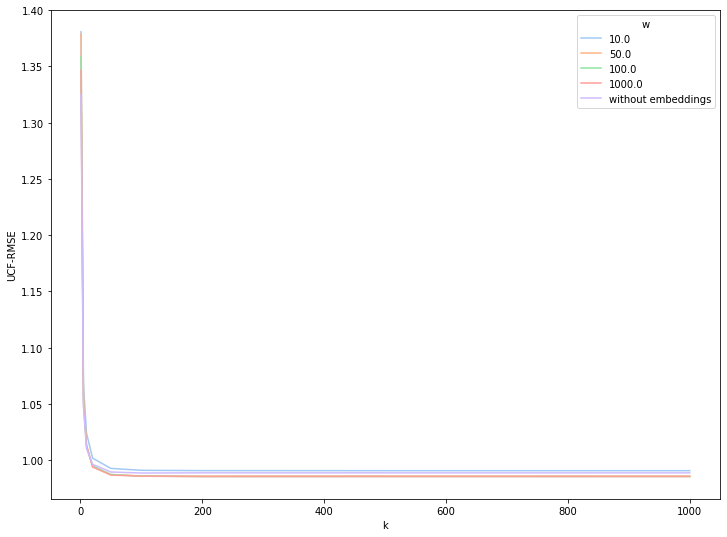

In [25]:
import seaborn as sns
from matplotlib import pyplot

dims = (12, 9)
fig, ax = pyplot.subplots(figsize=dims)
sns.lineplot(ax=ax, data=ucf_results_df, palette="pastel",x="k", y="UCF-RMSE", hue="w")

<AxesSubplot:xlabel='k', ylabel='ICF-RMSE'>

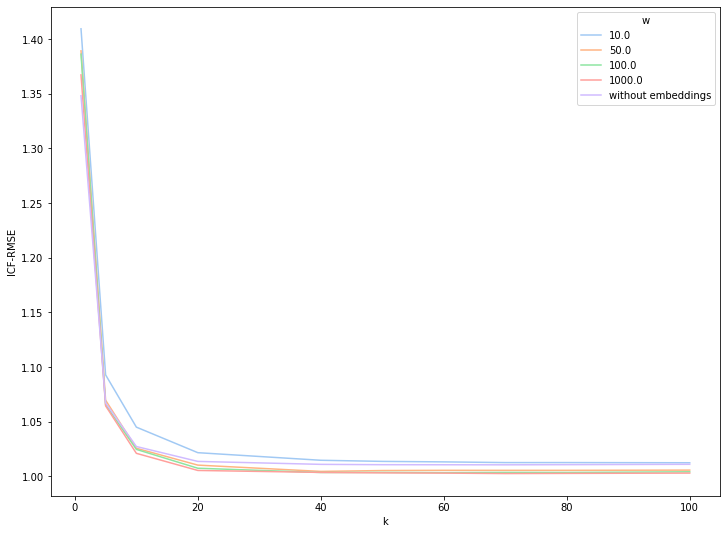

In [26]:
fig2, ax2 = pyplot.subplots(figsize=dims)
sns.lineplot(ax=ax2, data=icf_results_df, palette="pastel", x="k", y="ICF-RMSE", hue="w")